# Proof-of-principle that we can use the Lengyel model in the conductive region

Upstream of the conduction-convection interface, the assumptions of the Lengyel model hold, and so that model should be applicable in that region. We can demonstrate that neatly by switching from the full model to the Lengyel model at the interface, and then checking that the coupled model matches the full model.

In [1]:
## Every notebook should start with this header
# The next lines mean that changes in Python files are instantaneously applied
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path

# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")

import cfspopcon
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cfspopcon.unit_handling import ureg

import extended_lengyel
plt.rcParams['mathtext.default'] = 'regular'

Running in /Users/tbody/Projects/extended-lengyel/notebooks


In [2]:
def build_dataset(
    run_lengyel_model_in_conductive_layer = True,
    **overrides
):
    if run_lengyel_model_in_conductive_layer: 
        algorithm = cfspopcon.CompositeAlgorithm.from_list([
            "kallenbach_model_to_cc",
            "run_spatial_lengyel_model",
            "postprocess_spatial_lengyel_model"
        ])
    else: 
        algorithm = cfspopcon.Algorithm.get_algorithm("kallenbach_model")

    ds = xr.Dataset(data_vars=extended_lengyel.read_config(
        elements=["base", "target_constraints"],
        keys=algorithm.input_keys,
        allowed_missing=algorithm.default_keys,
        overrides=overrides,
    ))

    algorithm.validate_inputs(ds)

    ds = algorithm.update_dataset(ds)

    return ds

In [3]:
def promote_to_coordinate(array, units, dims):
    return xr.DataArray(array * units, coords={f"dim_{dims}": array})

inputs = dict(
    heat_flux_perp_to_target = promote_to_coordinate(np.logspace(np.log10(0.1), np.log10(10.0), num=10), ureg.MW / ureg.m**2, dims="heat_flux_perp_to_target"),
    target_electron_temp  = promote_to_coordinate(np.logspace(np.log10(2.0), np.log10(50), num=10), ureg.eV, dims="target_electron_temp"),
    impurity_fraction        = promote_to_coordinate([1.0, 2.0, 4.0], ureg.percent, dims="impurity_fraction"),
)

rcc_plus_lengyel_ds = build_dataset(**inputs, run_lengyel_model_in_conductive_layer = True)
rcc_reference_ds = build_dataset(**inputs, run_lengyel_model_in_conductive_layer = False)

The two models agree to within 1%.

In [4]:
xr.testing.assert_allclose(rcc_plus_lengyel_ds["separatrix_electron_density"], rcc_reference_ds["separatrix_electron_density"], rtol=1e-2)
xr.testing.assert_allclose(rcc_plus_lengyel_ds["separatrix_electron_temp"], rcc_reference_ds["separatrix_electron_temp"], rtol=1e-2)
xr.testing.assert_allclose(rcc_plus_lengyel_ds["q_parallel"], rcc_reference_ds["q_parallel"], rtol=1e-2)

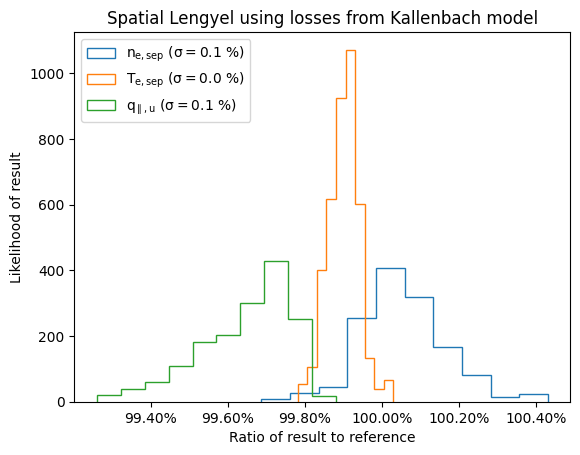

In [5]:
from matplotlib.ticker import PercentFormatter

import extended_lengyel.directories

rtol_separatrix_electron_density = (rcc_plus_lengyel_ds["separatrix_electron_density"] / rcc_reference_ds["separatrix_electron_density"].broadcast_like(rcc_plus_lengyel_ds["separatrix_electron_density"]))
rtol_separatrix_electron_temp = (rcc_plus_lengyel_ds["separatrix_electron_temp"] / rcc_reference_ds["separatrix_electron_temp"].broadcast_like(rcc_plus_lengyel_ds["separatrix_electron_temp"]))
rtol_q_parallel = (rcc_plus_lengyel_ds["q_parallel"] / rcc_reference_ds["q_parallel"].broadcast_like(rcc_plus_lengyel_ds["q_parallel"]))

fig, ax = plt.subplots()

kwargs = dict(histtype="step", density=True, stacked=True)

for label, result in {
    "$n_{e,sep}$": rtol_separatrix_electron_density,
    "$T_{e,sep}$": rtol_separatrix_electron_temp,
    "$q_{\\parallel,u}$": rtol_q_parallel,
}.items():
    std = result.std().item().to(ureg.percent)
    result.plot.hist(ax=ax, label=f"{label} ($\\sigma=${std:~.1f})", **kwargs)

ax.legend(loc="upper left")
ax.set_ylabel("Likelihood of result")
ax.set_xlabel("Ratio of result to reference")
ax.set_title("Spatial Lengyel using losses from Kallenbach model")

ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
# Something weird is going on with the normalization here
# ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))

plt.savefig(extended_lengyel.directories.output_dir / "rtol_for_spatial_lengyel_using_Kallenbach_losses.png", dpi=300)